
# Hitchhiker‑style Statistical Testing for Deep RL (SpinningUp backend)

This notebook provides an **end‑to‑end replication harness** based on *A Hitchhiker’s Guide to Statistical Comparisons of RL Algorithms* (Colas, Sigaud, Oudeyer, 2019), with the following features:

- **Algorithms (SpinningUp)**: `SAC`, `TD3`, `DDPG`, `PPO` (PyTorch variants).
- **Tasks (Gymnasium MuJoCo v4)**: `Hopper-v4`, `Walker2d-v4`, `HalfCheetah-v4`, `Ant-v4`, `Humanoid-v4`.
- **Evaluation**: **deterministic policy evaluation** (mean action) over `E=20` episodes per seed, as recommended in the guide.
- **Statistical tests** (two-sided):
  - Student’s *t* (equal-variance)  
  - **Welch’s *t*** (unequal-variance, recommended default in the guide)  
  - Mann–Whitney U  
  - Ranked *t*-test (apply *t* to pooled ranks; Welch variant)  
  - Bootstrap percentile CI test (mean- and median-difference)  
  - Permutation test on mean-difference
- **Operating characteristics**:
  - **False Positive Rate** (FPR) under a constructed null by re-centering (mean/median)  
  - **Power** under controlled mean shifts with **Cohen’s d** effect sizes `ε ∈ {0.5, 1.0, 2.0}`
- **Plots** (Matplotlib only; one chart per figure; default colors): FPR vs `N`, Power vs `N`.

> **Why these choices?** The Hitchhiker’s guide recommends deterministic offline evaluation (e.g., **E=20** episodes), shows **Welch’s t-test** as a robust default, and cautions about **bootstrap/permutation** at small `N` and **rank-based tests** under shape/variance violations. We follow those recommendations throughout the pipeline.

---

### How to run (quick start)

1. **Install** (next cell) – includes *Gymnasium* (MuJoCo) and **SpinningUp** (PyTorch).
2. Set **config** (algorithms, tasks, seeds, budgets). Start with small budgets to smoke-test.
3. Run **Train & Collect** – caches results per `(task, algo, seed)` and appends to a CSV.
4. Run **Statistics** – computes FPR/Power over your current results.
5. Use the **Plots** cells to visualize FPR/Power vs. `N`.



In [40]:
import gymnasium as gym
from stable_baselines3 import SAC, TD3, DDPG, PPO
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import numpy as np
import pandas as pd
import time
import os
from typing import Any, Dict, List, Tuple
import json
from scipy import stats

import matplotlib.pyplot as plt


In [41]:
BASE = os.getcwd() 

# Statistical testing configuration
SEED_GRID = [5, 10, 20, 30, 50]  # Sample sizes per group for FPR/Power analysis
ALPHAS = [0.05, 0.01]  # Significance levels
TESTS = ["student_t", "welch_t", "mannwhitney", "ranked_t", "bootstrap_mean_ci", "bootstrap_median_ci", "permutation_mean"]
EPSILONS = [0.5, 1.0, 2.0]  # Cohen's d effect sizes for power analysis
N_RESAMPLES = 1000  # Number of bootstrap/permutation resamples (reduce for faster iteration)

In [54]:
TASKS = [
    "Hopper-v5",
    "Walker2d-v5",
    "HalfCheetah-v5",
    "Ant-v5",
    "Humanoid-v5",
]

ALGORITHMS = ["SAC", "TD3", "DDPG", "PPO"]

EVAL_EPISODES = 20

TIMESTEPS_PER_TASK = {
    "Hopper-v5":      1_000_000,
    "Walker2d-v5":    1_000_000,
    "HalfCheetah-v5": 3_000_000,
    "Ant-v5":         3_000_000,
    "Humanoid-v5":   10_000_000,
}

DEFAULT_TOTAL_TIMESTEPS = 5_000_000

BASE_DIR = os.path.join(BASE, "rl_experiments")
RUNS_DIR = os.path.join(BASE_DIR, "runs")
MODELS_DIR = os.path.join(BASE_DIR, "models")
RESULTS_CSV = os.path.join(BASE_DIR, "final_eval_returns.csv")
LEARNING_CURVES_CSV = os.path.join(BASE_DIR, "learning_curves.csv")

os.makedirs(RUNS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

GLOBAL_RNG_SEED = 31415
np.random.seed(GLOBAL_RNG_SEED)

# configs

In [55]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer,)):
            return int(obj)
        if isinstance(obj, (np.floating,)):
            return float(obj)
        if isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return super().default(obj)

In [56]:
def make_env(env_id: str, seed: int):
    env = gym.make(env_id)
    _ = env.reset(seed=seed)
    return Monitor(env)


def _build_action_noise(env, sigma: float = 0.1):
    assert hasattr(env, "action_space")
    action_dim = env.action_space.shape[0]
    return NormalActionNoise(mean=np.zeros(action_dim),
                             sigma=sigma * np.ones(action_dim))


def make_model(algo: str, env: gym.Env, seed: int):
    algo = algo.upper()
    policy = "MlpPolicy"
    if algo == "SAC":
        model = SAC(policy, env, verbose=0, seed=seed)
    elif algo == "TD3":
        noise = _build_action_noise(env, sigma=0.1)
        model = TD3(policy, env, action_noise=noise, verbose=0, seed=seed)
    elif algo == "DDPG":
        noise = _build_action_noise(env, sigma=0.1)
        model = DDPG(policy, env, action_noise=noise, verbose=0, seed=seed)
    elif algo == "PPO":
        model = PPO(policy, env, verbose=0, seed=seed)
    else:
        raise ValueError(f"Unknown algorithm: {algo}")
    return model


def evaluate_policy_deterministic(model, env_id: str, n_episodes: int,
                                  eval_seed_base: int = 10_000):
    """Deterministic eval (mean action); returns list of episode returns and mean."""
    returns = []
    env = gym.make(env_id)
    for ep in range(n_episodes):
        obs, info = env.reset(seed=eval_seed_base + ep)
        terminated = False
        truncated = False
        ep_ret = 0.0
        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            ep_ret += float(reward)
        returns.append(ep_ret)
    env.close()
    return returns, float(np.mean(returns))

class EvalLoggerCallback(BaseCallback):
    def __init__(self,
                 env_id: str,
                 algo: str,
                 seed: int,
                 eval_freq: int,
                 eval_episodes: int,
                 csv_path: str = LEARNING_CURVES_CSV,
                 verbose: int = 0):
        super().__init__(verbose)
        self.env_id = env_id
        self.algo = algo
        self.seed = seed
        self.eval_freq = eval_freq
        self.eval_episodes = eval_episodes
        self.csv_path = csv_path

    def _on_step(self) -> bool:
        # self.num_timesteps is provided by BaseCallback / SB3
        if self.num_timesteps % self.eval_freq == 0:
            # run deterministic evaluation using your helper
            ep_returns, mean_ret = evaluate_policy_deterministic(
                self.model,          # SB3 model
                self.env_id,
                n_episodes=self.eval_episodes,
                eval_seed_base=100_000 + self.seed * 1000
            )

            row = {
                "timestamp": time.time(),
                "task": self.env_id,
                "algorithm": self.algo,
                "seed": self.seed,
                "env_steps": int(self.num_timesteps),
                "eval_episodes": self.eval_episodes,
                "eval_return_mean": float(mean_ret),
                "eval_return_std": float(np.std(ep_returns)),
            }

            df = pd.DataFrame([row])
            header = not os.path.exists(self.csv_path)
            df.to_csv(self.csv_path, mode="a", header=header, index=False)

            if self.verbose > 0:
                print(f"[EVAL] {self.env_id} | {self.algo} | seed={self.seed} "
                      f"| steps={self.num_timesteps} | return={mean_ret:.1f}")

        return True  # keep training

def train_one_seed(env_id: str, algo: str, seed: int,
                   total_timesteps: int | None = None,
                   eval_episodes: int = EVAL_EPISODES,
                   cache_dir: str = RUNS_DIR,
                   models_dir: str = MODELS_DIR,
                   skip_if_cached: bool = True) -> Dict[str, Any]:

    if total_timesteps is None:
        total_timesteps = TIMESTEPS_PER_TASK.get(env_id, DEFAULT_TOTAL_TIMESTEPS)

    run_tag = f"{env_id}_{algo}_seed{seed}"
    run_json = os.path.join(cache_dir, f"{run_tag}.json")
    model_path = os.path.join(models_dir, f"{run_tag}.zip")

    if skip_if_cached and os.path.exists(run_json):
        with open(run_json, "r") as f:
            return json.load(f)

    env = make_env(env_id, seed)
    model = make_model(algo, env, seed=seed)

    eval_freq = max(total_timesteps // 100, 10_000)

    eval_callback = EvalLoggerCallback(
        env_id=env_id,
        algo=algo,
        seed=seed,
        eval_freq=eval_freq,
        eval_episodes=eval_episodes,
        csv_path=LEARNING_CURVES_CSV,
        verbose=1,
    )

    print(f"[TRAIN] {run_tag} starting, timesteps={total_timesteps}")
    t0 = time.time()
    model.learn(
        total_timesteps=total_timesteps,
        progress_bar=True,
        callback=eval_callback,
    )
    t1 = time.time()
    print(f"[TRAIN] {run_tag} finished, elapsed seconds={t1 - t0:.2f}")
    try:
        model.save(model_path)
    except Exception as e:
        print(f"Warning: could not save model for {run_tag}: {e}")
    env.close()

    ep_returns, mean_return = evaluate_policy_deterministic(
        model, env_id, n_episodes=eval_episodes,
        eval_seed_base=100_000 + seed * 1000
    )

    result = {
        "timestamp": time.time(),
        "task": env_id,
        "algorithm": algo,
        "seed": seed,
        "total_timesteps": int(total_timesteps),
        "eval_episodes": int(eval_episodes),
        "episode_returns": ep_returns,
        "final_return_mean": float(mean_return),
        "model_path": model_path if os.path.exists(model_path) else None,
    }

    with open(run_json, "w") as f:
        json.dump(result, f, cls=NpEncoder)

    return result


def append_to_master_csv(record: Dict[str, Any], csv_path: str = RESULTS_CSV):
    row = {
        "timestamp": record.get("timestamp", time.time()),
        "task": record["task"],
        "algorithm": record["algorithm"],
        "seed": record["seed"],
        "total_timesteps": record.get("total_timesteps", np.nan),
        "eval_episodes": record.get("eval_episodes", np.nan),
        "final_return_mean": record["final_return_mean"],
    }
    df = pd.DataFrame([row])
    header = not os.path.exists(csv_path)
    df.to_csv(csv_path, mode="a", header=header, index=False)


def train_and_collect(tasks: List[str], algos: List[str], seeds: List[int],
                      total_timesteps: int | None = None,
                      eval_episodes: int = EVAL_EPISODES,
                      skip_if_cached: bool = True) -> pd.DataFrame:
    for env_id in tasks:
        for algo in algos:
            for seed in seeds:
                print(f"\n=== Training {env_id} | {algo} | seed={seed} ===")
                rec = train_one_seed(
                    env_id,
                    algo,
                    seed,
                    # if total_timesteps is None, train_one_seed will look up TIMESTEPS_PER_TASK
                    total_timesteps=total_timesteps,
                    eval_episodes=eval_episodes,
                    skip_if_cached=skip_if_cached
                )
                append_to_master_csv(rec, RESULTS_CSV)

    if os.path.exists(RESULTS_CSV):
        return pd.read_csv(RESULTS_CSV)
    else:
        return pd.DataFrame(columns=[
            "timestamp", "task", "algorithm", "seed",
            "total_timesteps", "eval_episodes", "final_return_mean"
        ])


# actual exp

In [57]:
USE_TASKS = TASKS
USE_ALGOS = ALGORITHMS
USE_SEEDS = list(range(5))

df_runs = train_and_collect(
    tasks=USE_TASKS,
    algos=USE_ALGOS,
    seeds=USE_SEEDS,
    total_timesteps=None,
    eval_episodes=EVAL_EPISODES,
    skip_if_cached=True,
)


=== Training Hopper-v5 | SAC | seed=0 ===

=== Training Hopper-v5 | SAC | seed=1 ===

=== Training Hopper-v5 | SAC | seed=2 ===

=== Training Hopper-v5 | SAC | seed=3 ===

=== Training Hopper-v5 | SAC | seed=4 ===

=== Training Hopper-v5 | TD3 | seed=0 ===

=== Training Hopper-v5 | TD3 | seed=1 ===

=== Training Hopper-v5 | TD3 | seed=2 ===

=== Training Hopper-v5 | TD3 | seed=3 ===

=== Training Hopper-v5 | TD3 | seed=4 ===

=== Training Hopper-v5 | DDPG | seed=0 ===

=== Training Hopper-v5 | DDPG | seed=1 ===

=== Training Hopper-v5 | DDPG | seed=2 ===

=== Training Hopper-v5 | DDPG | seed=3 ===

=== Training Hopper-v5 | DDPG | seed=4 ===

=== Training Hopper-v5 | PPO | seed=0 ===

=== Training Hopper-v5 | PPO | seed=1 ===

=== Training Hopper-v5 | PPO | seed=2 ===

=== Training Hopper-v5 | PPO | seed=3 ===

=== Training Hopper-v5 | PPO | seed=4 ===

=== Training Walker2d-v5 | SAC | seed=0 ===

=== Training Walker2d-v5 | SAC | seed=1 ===

=== Training Walker2d-v5 | SAC | seed=2 ===


## plotting lc

In [46]:
# Load learning curves
assert os.path.exists(LEARNING_CURVES_CSV), f"No learning curves file at {LEARNING_CURVES_CSV}"
curves = pd.read_csv(LEARNING_CURVES_CSV)
print(curves.shape)

(11078, 8)


In [47]:
def plot_task_learning_curves(task: str,
                              algos: List[str],
                              steps_scale: float = 1e6,
                              use_std_band: bool = True):
    """
    Plot mean +/- std (or min/max) across seeds for each algo on a given task.
    steps_scale=1e6 -> x-axis in 'million steps', like SAC paper.
    """
    task_df = curves[curves["task"] == task]

    plt.figure(figsize=(6,4))
    for algo in algos:
        df_a = task_df[task_df["algorithm"] == algo]
        if df_a.empty:
            continue

        # group by env_steps across seeds
        grp = df_a.groupby("env_steps")

        steps = np.array(list(grp.groups.keys()))
        means = grp["eval_return_mean"].mean().values

        if use_std_band:
            spread = grp["eval_return_mean"].std().values
            lo = means - spread
            hi = means + spread
        else:
            # min/max band like SAC figure
            lo = grp["eval_return_mean"].min().values
            hi = grp["eval_return_mean"].max().values

        x = steps / steps_scale

        plt.plot(x, means, label=algo)
        plt.fill_between(x, lo, hi, alpha=0.2)

    plt.xlabel("environment steps (millions)")
    plt.ylabel("average return")
    plt.title(task)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


### the plots

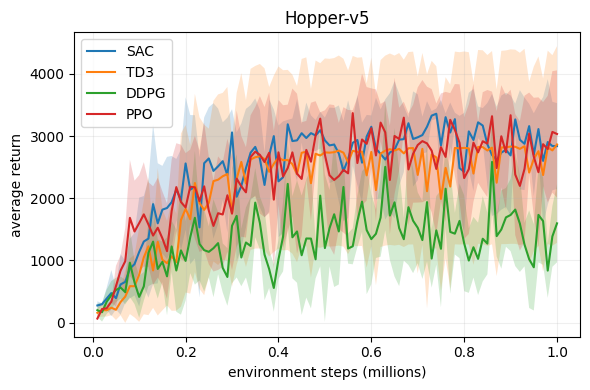

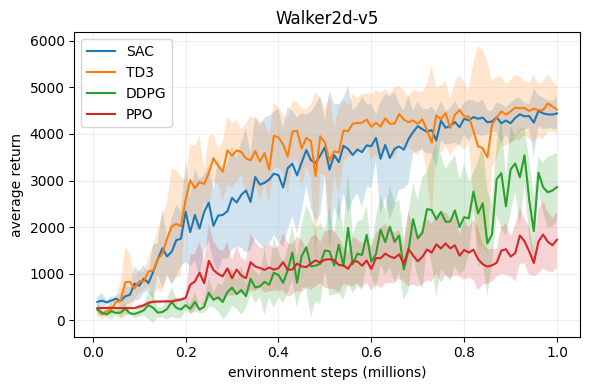

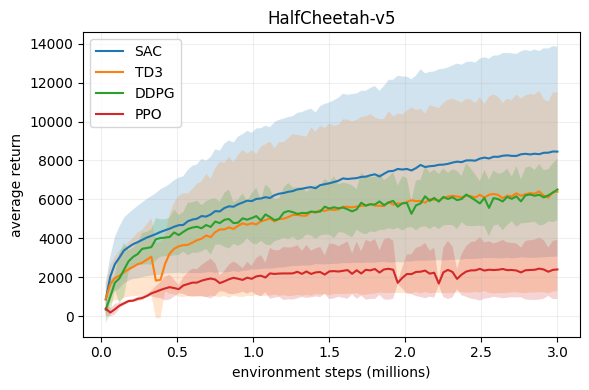

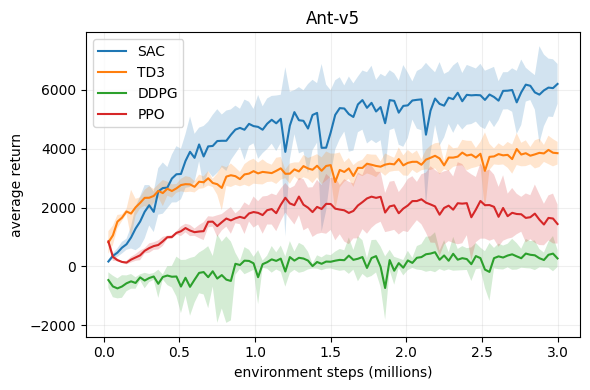

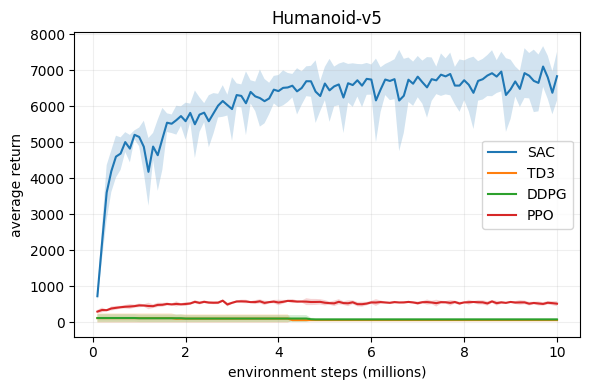

In [48]:
for task in TASKS:
  plot_task_learning_curves(task, algos=["SAC", "TD3", "DDPG", "PPO"])

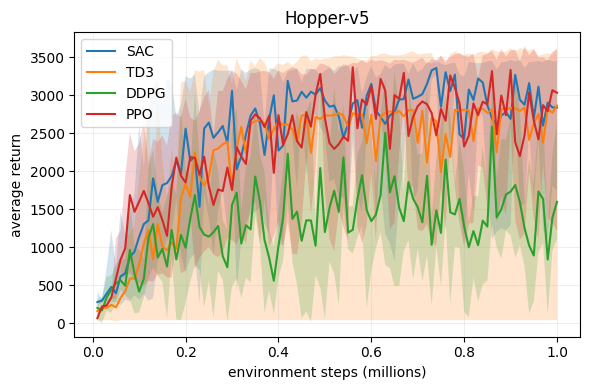

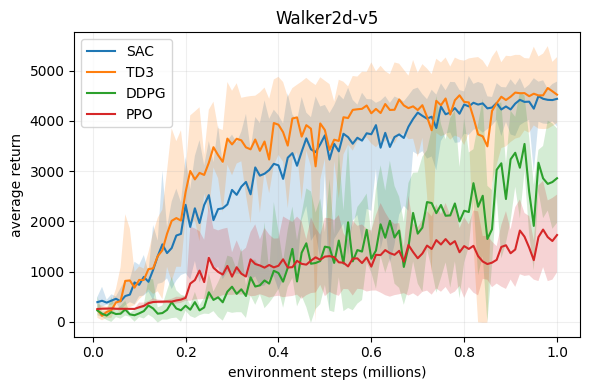

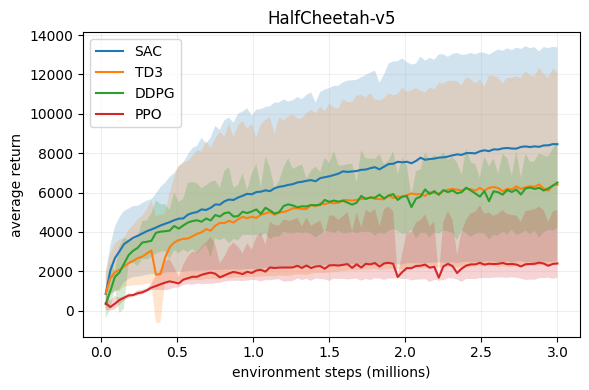

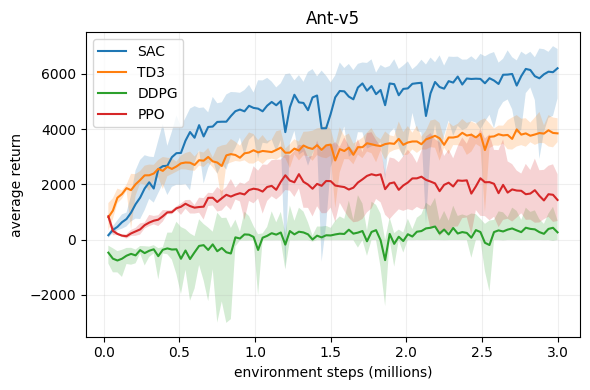

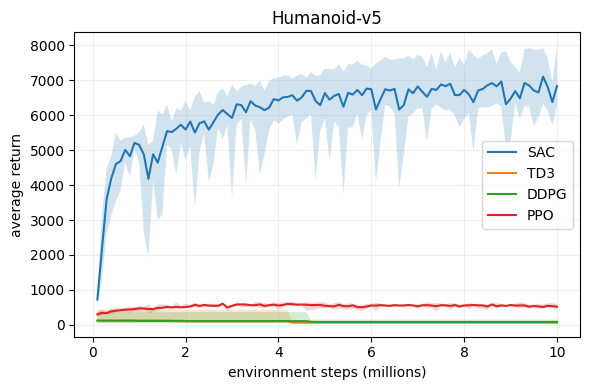

In [49]:
for task in TASKS:
  plot_task_learning_curves(task, algos=["SAC", "TD3", "DDPG", "PPO"], use_std_band = False)


# Statistical tests (Hitchhiker suite)

Two‑sample, two‑sided tests comparing either means or medians:
- Student’s *t* (equal variances)  
- **Welch’s *t*** (unequal variances; robust default)  
- Mann–Whitney U (assumes similar shapes/spreads; can misfire when violated)  
- Ranked *t*-test (Welch on pooled ranks; close to Mann–Whitney)  
- **Bootstrap percentile CI** for mean/median difference (reject if 0 outside CI)  
- **Permutation** test on mean difference


In [58]:
def ttest_student(a, b):
    res = stats.ttest_ind(a, b, equal_var=True, alternative="two-sided")
    return float(res.pvalue)

def ttest_welch(a, b):
    res = stats.ttest_ind(a, b, equal_var=False, alternative="two-sided")
    return float(res.pvalue)

def mannwhitney_twosided(a, b):
    res = stats.mannwhitneyu(a, b, alternative="two-sided", method="auto")
    return float(res.pvalue)

def ranked_ttest_welch(a, b):
    a = np.asarray(a); b = np.asarray(b)
    pooled = np.concatenate([a, b])
    ranks = stats.rankdata(pooled, method="average")
    ra = ranks[: len(a)]
    rb = ranks[len(a):]
    res = stats.ttest_ind(ra, rb, equal_var=False, alternative="two-sided")
    return float(res.pvalue)

def bootstrap_mean_ci_test(a, b, alpha=0.05, n_resamples=1000, random_state=None):
    '''Percentile bootstrap for mean-difference; reject if 0 outside CI.'''
    rng = np.random.default_rng(random_state)
    a = np.asarray(a); b = np.asarray(b)
    n, m = len(a), len(b)
    diffs = []
    for _ in range(n_resamples):
        sa = rng.choice(a, size=n, replace=True)
        sb = rng.choice(b, size=m, replace=True)
        diffs.append(np.mean(sa) - np.mean(sb))
    diffs = np.asarray(diffs)
    lo = np.percentile(diffs, 100 * (alpha/2))
    hi = np.percentile(diffs, 100 * (1 - alpha/2))
    reject = not (lo <= 0.0 <= hi)
    p_est = 2 * min(np.mean(diffs <= 0.0), np.mean(diffs >= 0.0))
    return float(p_est), (float(lo), float(hi)), bool(reject)

def bootstrap_median_ci_test(a, b, alpha=0.05, n_resamples=1000, random_state=None):
    '''Percentile bootstrap for median-difference; reject if 0 outside CI.'''
    rng = np.random.default_rng(random_state)
    a = np.asarray(a); b = np.asarray(b)
    n, m = len(a), len(b)
    diffs = []
    for _ in range(n_resamples):
        sa = rng.choice(a, size=n, replace=True)
        sb = rng.choice(b, size=m, replace=True)
        diffs.append(np.median(sa) - np.median(sb))
    diffs = np.asarray(diffs)
    lo = np.percentile(diffs, 100 * (alpha/2))
    hi = np.percentile(diffs, 100 * (1 - alpha/2))
    reject = not (lo <= 0.0 <= hi)
    p_est = 2 * min(np.mean(diffs <= 0.0), np.mean(diffs >= 0.0))
    return float(p_est), (float(lo), float(hi)), bool(reject)

def permutation_mean_test(a, b, n_resamples=1000, random_state=None):
    '''Random-label permutation test on mean-difference (two-sided).'''
    rng = np.random.default_rng(random_state)
    a = np.asarray(a); b = np.asarray(b)
    n = len(a)
    pooled = np.concatenate([a, b]).copy()
    obs = float(np.mean(a) - np.mean(b))
    count = 0
    for _ in range(n_resamples):
        rng.shuffle(pooled)
        a_perm = pooled[:n]
        b_perm = pooled[n:]
        diff = float(np.mean(a_perm) - np.mean(b_perm))
        if abs(diff) >= abs(obs):
            count += 1
    p = (count + 1) / (n_resamples + 1)
    return float(p)

TEST_FUNCS = {
    "student_t": ttest_student,
    "welch_t": ttest_welch,
    "mannwhitney": mannwhitney_twosided,
    "ranked_t": ranked_ttest_welch,
    "bootstrap_mean_ci": bootstrap_mean_ci_test,
    "bootstrap_median_ci": bootstrap_median_ci_test,
    "permutation_mean": permutation_mean_test,
}



## Operating characteristics: FPR & Power

- **FPR** under **H0**: re-center each sample by **mean** (or **median**) so the target parameter is equal; resample and test.  
- **Power** under **H1**: resample and inject a mean shift `Δ = ε × s_pooled` (Cohen’s d), preserving empirical shapes.


In [59]:

def recenter_samples(a, b, which="mean"):
    a = np.asarray(a); b = np.asarray(b)
    if which == "mean":
        return a - np.mean(a), b - np.mean(b)
    elif which == "median":
        return a - np.median(a), b - np.median(b)
    else:
        raise ValueError("which = 'mean' or 'median'")

def pooled_std(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    va = np.var(a, ddof=1) if na > 1 else 0.0
    vb = np.var(b, ddof=1) if nb > 1 else 0.0
    if na + nb - 2 <= 0:
        return 0.0
    sp2 = ((na - 1) * va + (nb - 1) * vb) / (na + nb - 2)
    return float(np.sqrt(max(sp2, 0.0)))

def estimate_fpr(a_emp, b_emp, test_name: str, N: int, alpha: float,
                 center_by: str = "mean", n_resamples: int = 1000, random_state: int = 0) -> float:
    rng = np.random.default_rng(random_state)
    a0, b0 = recenter_samples(a_emp, b_emp, which=center_by)
    nA = N; nB = N
    false_rejects = 0
    for _ in range(n_resamples):
        sa = rng.choice(a0, size=nA, replace=True)
        sb = rng.choice(b0, size=nB, replace=True)

        if test_name in ("bootstrap_mean_ci", "bootstrap_median_ci"):
            if test_name == "bootstrap_mean_ci":
                p_est, _, reject = bootstrap_mean_ci_test(sa, sb, alpha=alpha, n_resamples=200,
                                                          random_state=rng.integers(1e9))
            else:
                p_est, _, reject = bootstrap_median_ci_test(sa, sb, alpha=alpha, n_resamples=200,
                                                            random_state=rng.integers(1e9))
        elif test_name == "permutation_mean":
            pval = permutation_mean_test(sa, sb, n_resamples=500, random_state=rng.integers(1e9))
            reject = pval < alpha
        else:
            pval = TEST_FUNCS[test_name](sa, sb)
            reject = pval < alpha

        if reject:
            false_rejects += 1

    return false_rejects / n_resamples

def estimate_power(a_emp, b_emp, test_name: str, N: int, alpha: float, epsilon: float,
                   n_resamples: int = 1000, random_state: int = 0) -> float:
    '''Estimate power by resampling and injecting Δ = ε * s_pooled into group A.'''
    rng = np.random.default_rng(random_state)
    a_emp = np.asarray(a_emp); b_emp = np.asarray(b_emp)
    nA = N; nB = N
    sp = pooled_std(a_emp, b_emp)
    delta = epsilon * sp

    hits = 0
    for _ in range(n_resamples):
        sa = rng.choice(a_emp, size=nA, replace=True) + delta
        sb = rng.choice(b_emp, size=nB, replace=True)

        if test_name in ("bootstrap_mean_ci", "bootstrap_median_ci"):
            if test_name == "bootstrap_mean_ci":
                p_est, _, reject = bootstrap_mean_ci_test(sa, sb, alpha=alpha, n_resamples=200,
                                                          random_state=rng.integers(1e9))
            else:
                p_est, _, reject = bootstrap_median_ci_test(sa, sb, alpha=alpha, n_resamples=200,
                                                            random_state=rng.integers(1e9))
        elif test_name == "permutation_mean":
            pval = permutation_mean_test(sa, sb, n_resamples=500, random_state=rng.integers(1e9))
            reject = pval < alpha
        else:
            pval = TEST_FUNCS[test_name](sa, sb)
            reject = pval < alpha

        if reject:
            hits += 1

    return hits / n_resamples



## Data aggregation

Utilities to load the master CSV and collect per-(task, algo) samples of final evaluation returns.


In [60]:

def load_results(csv_path: str = RESULTS_CSV) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        pd.DataFrame(columns=["timestamp","task","algorithm","seed","total_timesteps","eval_episodes","final_return_mean"]).to_csv(csv_path, index=False)
    df = pd.read_csv(csv_path)
    return df

def samples_by_task_algo(df: pd.DataFrame) -> Dict[Tuple[str,str], np.ndarray]:
    out = {}
    grouped = df.groupby(["task", "algorithm"])
    for (task, algo), g in grouped:
        vals = g.sort_values("seed")["final_return_mean"].to_numpy(dtype=float)
        out[(task, algo)] = vals
    return out

def all_pairs_for_task(samples: Dict[Tuple[str,str], np.ndarray], task: str, algos: List[str]) -> List[Tuple[str,str]]:
    algos = [a for a in algos if (task, a) in samples]
    pairs = []
    for i in range(len(algos)):
        for j in range(i+1, len(algos)):
            pairs.append((algos[i], algos[j]))
    return pairs



## Run operating‑characteristics sweeps

For each **task** and algorithm **pair (A, B)**, compute:
- **FPR** at `α ∈ {0.05, 0.01}` for `N ∈ {5,10,20,30,50}`
- **Power** for effect sizes `ε ∈ {0.5,1,2}` at the same grids


In [ ]:

def compute_operating_characteristics(df: pd.DataFrame,
                                      tasks: List[str],
                                      algos: List[str],
                                      seed_grid = None,
                                      alphas = None,
                                      tests = None,
                                      epsilons = None,
                                      n_resamples = None,
                                      center_by = "mean",
                                      random_state = 0) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Use globals if not provided, but fail with clear error if Cell 3 wasn't run
    if seed_grid is None: 
        try:
            seed_grid = SEED_GRID
        except NameError:
            raise NameError("SEED_GRID not defined. Please run Cell 3 first to set up configuration variables.")
    if alphas is None: 
        try:
            alphas = ALPHAS
        except NameError:
            raise NameError("ALPHAS not defined. Please run Cell 3 first.")
    if tests is None: 
        try:
            tests = TESTS
        except NameError:
            raise NameError("TESTS not defined. Please run Cell 3 first.")
    if epsilons is None: 
        try:
            epsilons = EPSILONS
        except NameError:
            raise NameError("EPSILONS not defined. Please run Cell 3 first.")
    if n_resamples is None: 
        try:
            n_resamples = N_RESAMPLES
        except NameError:
            raise NameError("N_RESAMPLES not defined. Please run Cell 3 first.")
    
    samples = samples_by_task_algo(df)
    fpr_rows = []
    power_rows = []
    for task in tasks:
        pairs = all_pairs_for_task(samples, task, algos)
        if not pairs:
            print(f"[warn] no pairs for task={task}")
            continue
        for (a1, a2) in pairs:
            sA = samples[(task, a1)]
            sB = samples[(task, a2)]
            if len(sA) == 0 or len(sB) == 0:
                continue
            for test_name in tests:
                for alpha in alphas:
                    for N in seed_grid:
                        fpr = estimate_fpr(sA, sB, test_name, N=N, alpha=alpha,
                                           center_by=center_by, n_resamples=n_resamples,
                                           random_state=random_state)
                        fpr_rows.append(dict(task=task, algo_A=a1, algo_B=a2,
                                             test=test_name, alpha=alpha, N=N, FPR=fpr))
                        for eps in epsilons:
                            pw = estimate_power(sA, sB, test_name, N=N, alpha=alpha,
                                                epsilon=eps, n_resamples=n_resamples,
                                                random_state=random_state)
                            power_rows.append(dict(task=task, algo_A=a1, algo_B=a2,
                                                   test=test_name, alpha=alpha, N=N,
                                                   epsilon=eps, Power=pw))
    return pd.DataFrame(fpr_rows), pd.DataFrame(power_rows)



## Plotting utilities

One chart per figure, **no seaborn**, default Matplotlib colors.


In [35]:

def plot_fpr(fpr_df: pd.DataFrame, task: str, pair: Tuple[str,str], alpha: float):
    df = fpr_df[(fpr_df["task"] == task) &
                (fpr_df["algo_A"] == pair[0]) &
                (fpr_df["algo_B"] == pair[1]) &
                (fpr_df["alpha"] == alpha)]
    if df.empty:
        print("No FPR data for this selection.")
        return
    plt.figure()
    for test_name in sorted(df["test"].unique()):
        sub = df[df["test"] == test_name].sort_values("N")
        plt.plot(sub["N"], sub["FPR"], marker="o", label=test_name)
    plt.axhline(y=alpha, linestyle="--")
    plt.title(f"FPR vs N (task={task}, pair={pair[0]} vs {pair[1]}, alpha={alpha})")
    plt.xlabel("Sample size per method (N)")
    plt.ylabel("False Positive Rate")
    plt.legend()
    plt.show()

def plot_power(power_df: pd.DataFrame, task: str, pair: Tuple[str,str], alpha: float, epsilon: float):
    df = power_df[(power_df["task"] == task) &
                  (power_df["algo_A"] == pair[0]) &
                  (power_df["algo_B"] == pair[1]) &
                  (power_df["alpha"] == alpha) &
                  (power_df["epsilon"] == epsilon)]
    if df.empty:
        print("No Power data for this selection.")
        return
    plt.figure()
    for test_name in sorted(df["test"].unique()):
        sub = df[df["test"] == test_name].sort_values("N")
        plt.plot(sub["N"], sub["Power"], marker="o", label=test_name)
    plt.title(f"Power vs N (task={task}, pair={pair[0]} vs {pair[1]}, alpha={alpha}, epsilon={epsilon})")
    plt.xlabel("Sample size per method (N)")
    plt.ylabel("Power")
    plt.legend()
    plt.show()



## Example: small smoke test

Runs a tiny grid with your current `USE_TASKS`, `USE_ALGOS`, `USE_SEEDS` and budget.  
Re-runs are **cached**; set `skip_if_cached=False` to force retraining.


In [36]:

# Train & collect (using stable-baselines3)
# Note: Training is already done via SLURM jobs. This cell loads existing results.
# To retrain, uncomment the code below or use Cell 9.

# Uncomment to train locally (will use cached results if available):
# demo_df = train_and_collect(
#     tasks=USE_TASKS,
#     algos=USE_ALGOS,
#     seeds=USE_SEEDS,
#     total_timesteps=None,  # Uses TIMESTEPS_PER_TASK
#     eval_episodes=EVAL_EPISODES,
#     skip_if_cached=True,
# )
# print(f"Aggregated rows: {len(demo_df)}")
# display(demo_df.tail(10))

# Load existing results instead:
if os.path.exists(RESULTS_CSV):
    demo_df = pd.read_csv(RESULTS_CSV)
    print(f"Loaded {len(demo_df)} rows from {RESULTS_CSV}")
    display(demo_df.tail(10))
else:
    print(f"No results found at {RESULTS_CSV}. Run training first (Cell 9) or wait for SLURM jobs to complete.")


Loaded 205 rows from /n/home09/annabelma/rl_final_proj/rl_experiments/final_eval_returns.csv


,timestamp,task,algorithm,seed,total_timesteps,eval_episodes,final_return_mean
195,1.764576e+09,Humanoid-v5,DDPG,0,10000000,20,56.390695
196,1.764578e+09,Humanoid-v5,DDPG,1,10000000,20,148.790159
197,1.764576e+09,Humanoid-v5,DDPG,2,10000000,20,86.051758
198,1.764574e+09,Humanoid-v5,DDPG,3,10000000,20,56.454322
199,1.764575e+09,Humanoid-v5,DDPG,4,10000000,20,60.652951
200,1.764390e+09,Humanoid-v5,PPO,0,10000000,20,489.623954
201,1.764390e+09,Humanoid-v5,PPO,1,10000000,20,547.903874
202,1.764390e+09,Humanoid-v5,PPO,2,10000000,20,528.703860
203,1.764390e+09,Humanoid-v5,PPO,3,10000000,20,574.054561
204,1.764390e+09,Humanoid-v5,PPO,4,10000000,20,383.877023



### Compute operating characteristics on your current results

> For fast iteration, reduce `N_RESAMPLES` in the config cell (e.g., 200–500).


In [53]:

# Load YOUR actual experimental results
df_all = load_results(RESULTS_CSV)
print(f"Loaded {len(df_all)} experimental results from your SLURM runs")
print(f"Unique tasks: {sorted(df_all.task.unique()) if len(df_all)>0 else []}")
print(f"Unique algos: {sorted(df_all.algorithm.unique()) if len(df_all)>0 else []}")
print("\nCounts per (task, algo):")
display(df_all.groupby(["task","algorithm"]).size())

if len(df_all) > 0:
    # Get actual tasks and algorithms from YOUR data
    actual_tasks = sorted(df_all.task.unique().tolist())
    actual_algos = sorted(df_all.algorithm.unique().tolist())
    
    print(f"\nUsing YOUR data: {len(actual_tasks)} tasks, {len(actual_algos)} algorithms")
    print(f"Tasks: {actual_tasks}")
    print(f"Algorithms: {actual_algos}")
    
    print("\nComputing FPR and Power using YOUR experimental results...")
    print("(Note: SEED_GRID, ALPHAS, TESTS, EPSILONS from Cell 3 define the analysis grid)")
    
    # Use YOUR actual data - config variables just define the analysis parameters
    fpr_df, power_df = compute_operating_characteristics(
        df_all,  # YOUR actual results dataframe
        tasks=actual_tasks,   # Use tasks from YOUR data
        algos=actual_algos,  # Use algorithms from YOUR data
    )
    print("\nFPR head:"); display(fpr_df.head())
    print("Power head:"); display(power_df.head())

    # Save
    fpr_path = os.path.join(BASE_DIR, "fpr_results.csv")
    power_path = os.path.join(BASE_DIR, "power_results.csv")
    fpr_df.to_csv(fpr_path, index=False)
    power_df.to_csv(power_path, index=False)
    print("\nSaved:", fpr_path)
    print("Saved:", power_path)
else:
    print("No results found. Check that RESULTS_CSV exists and contains data.")


Loaded 305 experimental results from your SLURM runs
Unique tasks: ['Ant-v5', 'HalfCheetah-v5', 'Hopper-v5', 'Humanoid-v5', 'Walker2d-v5']
Unique algos: ['DDPG', 'PPO', 'SAC', 'TD3']

Counts per (task, algo):


task            algorithm
Ant-v5          DDPG         15
                PPO          15
                SAC          15
                TD3          15
HalfCheetah-v5  DDPG         15
                PPO          15
                SAC          15
                TD3          15
Hopper-v5       DDPG         15
                PPO          15
                SAC          15
                TD3          15
Humanoid-v5     DDPG         15
                PPO          20
                SAC          15
                TD3          15
Walker2d-v5     DDPG         15
                PPO          15
                SAC          15
                TD3          15
dtype: int64


Using YOUR data: 5 tasks, 4 algorithms
Tasks: ['Ant-v5', 'HalfCheetah-v5', 'Hopper-v5', 'Humanoid-v5', 'Walker2d-v5']
Algorithms: ['DDPG', 'PPO', 'SAC', 'TD3']

Computing FPR and Power using YOUR experimental results...
(Note: SEED_GRID, ALPHAS, TESTS, EPSILONS from Cell 3 define the analysis grid)


NameError: name 'SEED_GRID' is not defined


### Plot examples

Pick the first available pair to quickly visualize FPR and Power.


In [28]:

samples = samples_by_task_algo(load_results(RESULTS_CSV))
some_task = None
some_pair = None
for t in USE_TASKS:
    pairs = all_pairs_for_task(samples, t, USE_ALGOS)
    if pairs:
        some_task = t
        some_pair = pairs[0]
        break

if some_task is not None:
    try:
        plot_fpr(fpr_df, task=some_task, pair=some_pair, alpha=0.05)
        plot_power(power_df, task=some_task, pair=some_pair, alpha=0.05, epsilon=1.0)
    except NameError:
        print("Compute the operating characteristics first.")
else:
    print("Not enough data to plot; train more runs.")


Compute the operating characteristics first.



## Notes aligning with the Hitchhiker guide

- **Evaluation protocol**: deterministic offline evaluation (`E=20` episodes) using a deterministic version of the policy (mean action for max‑entropy methods).  
- **Robust default**: **Welch’s t-test** tends to maintain lower false positive rates across conditions; consider **α=0.01** when in doubt.  
- **Small `N` caveats**: **bootstrap** and **permutation** tests **over‑reject** at small `N`; rank‑based tests (**Mann–Whitney**, **ranked *t**)** can misfire under shape/spread violations (e.g., skewed vs symmetric).  
- **Power vs. `N`** (rules of thumb): relative effect `ε=0.5 → N≈100`, `ε=1.0 → N≈20`, `ε=2.0 → N≈5–10`.

These are reflected directly in the pipeline (null construction, test suite, FPR/Power sweeps).


In [ ]:
# ====== SKIP THIS CELL - Use cells above instead ======
# This cell was a Colab-only quick demo. Your actual data is already loaded.
# Run Cell 29 to compute operating characteristics on your SLURM results.
print("This cell is disabled. Use the cells above (especially Cell 29) for statistical analysis.")


In [ ]:
# ====== SUMMARY TABLES (like Tables 1-2 in Hitchhiker's Guide) ======

# Aggregate FPR across all task/algo pairs
print("FPR Summary by Test and N (averaged across task/algo pairs, alpha=0.05):")
fpr_05 = fpr_df[fpr_df["alpha"] == 0.05].groupby(["test", "N"])["FPR"].mean().unstack()
display(fpr_05.round(3))

print("\nPower Summary by Test and N (averaged, alpha=0.05, epsilon=1.0):")
power_filtered = power_df[(power_df["alpha"] == 0.05) & (power_df["epsilon"] == 1.0)]
power_summ = power_filtered.groupby(["test", "N"])["Power"].mean().unstack()
display(power_summ.round(3))

print("\nHitchhiker's Guide Recommendations:")
print("- Welch's t-test is robust default")
print("- FPR should be close to alpha (0.05)")
print("- Power > 0.8 is typically desired")
print("- Small N: bootstrap/permutation can over-reject")


In [ ]:
# ====== DIRECT ALGORITHM COMPARISONS ======
# Perform actual statistical tests on your data using Welch's t-test (recommended)

print("=" * 80)
print("DIRECT COMPARISONS: Welch's t-test results for all algorithm pairs")
print("=" * 80)

df_all = load_results(RESULTS_CSV)
samples = samples_by_task_algo(df_all)

comparison_rows = []
for task in TASKS:
    pairs = all_pairs_for_task(samples, task, ALGORITHMS)
    for (a1, a2) in pairs:
        s1 = samples.get((task, a1), np.array([]))
        s2 = samples.get((task, a2), np.array([]))
        if len(s1) < 2 or len(s2) < 2:
            continue
        
        # Compute statistics
        mean1, mean2 = np.mean(s1), np.mean(s2)
        std1, std2 = np.std(s1, ddof=1), np.std(s2, ddof=1)
        
        # Welch's t-test
        pval = ttest_welch(s1, s2)
        
        # Effect size (Cohen's d)
        sp = pooled_std(s1, s2)
        d = (mean1 - mean2) / sp if sp > 0 else 0
        
        comparison_rows.append({
            "Task": task,
            "Algo_A": a1,
            "Algo_B": a2,
            "Mean_A": mean1,
            "Mean_B": mean2,
            "Std_A": std1,
            "Std_B": std2,
            "Cohen_d": d,
            "p_value": pval,
            "Significant_005": pval < 0.05,
            "Significant_001": pval < 0.01,
        })

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df.round(3))

# Summary
print("\n" + "=" * 80)
print("SIGNIFICANT DIFFERENCES (p < 0.05):")
print("=" * 80)
sig = comparison_df[comparison_df["Significant_005"]]
if len(sig) > 0:
    for _, row in sig.iterrows():
        winner = row["Algo_A"] if row["Mean_A"] > row["Mean_B"] else row["Algo_B"]
        print(f"  {row['Task']}: {row['Algo_A']} vs {row['Algo_B']} - "
              f"p={row['p_value']:.4f}, d={row['Cohen_d']:.2f}, winner: {winner}")
else:
    print("  No significant differences found at p < 0.05")


In [ ]:
# ====== COMPREHENSIVE HITCHHIKER ANALYSIS ======
# Plot FPR and Power for ALL algorithm pairs across ALL tasks

# Reload data and compute stats if not already done
if 'fpr_df' not in dir() or 'power_df' not in dir():
    df_all = load_results(RESULTS_CSV)
    print(f"Computing operating characteristics for {len(df_all)} runs...")
    fpr_df, power_df = compute_operating_characteristics(
        df_all,
        tasks=TASKS,
        algos=ALGORITHMS,
        seed_grid=SEED_GRID,
        alphas=ALPHAS,
        tests=TESTS,
        epsilons=EPSILONS,
        n_resamples=N_RESAMPLES,
        center_by="mean",
        random_state=GLOBAL_RNG_SEED,
    )
    print("Done!")

# Get all available samples
samples = samples_by_task_algo(load_results(RESULTS_CSV))

# Plot FPR for all tasks and algorithm pairs
print("=" * 60)
print("FALSE POSITIVE RATE (FPR) ANALYSIS")
print("=" * 60)
for task in TASKS:
    pairs = all_pairs_for_task(samples, task, ALGORITHMS)
    for pair in pairs:
        for alpha in ALPHAS:
            plot_fpr(fpr_df, task=task, pair=pair, alpha=alpha)

# Plot Power for all tasks and algorithm pairs
print("=" * 60)
print("STATISTICAL POWER ANALYSIS")  
print("=" * 60)
for task in TASKS:
    pairs = all_pairs_for_task(samples, task, ALGORITHMS)
    for pair in pairs:
        for alpha in ALPHAS:
            for epsilon in EPSILONS:
                plot_power(power_df, task=task, pair=pair, alpha=alpha, epsilon=epsilon)
